In [2]:
import os
import pickle 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
import shap

In [ ]:
def plot_top_shap_per_class(class_name, class_names, shap_values, feature_names, top_n=10):
    """
    Plot the top N features for a given class using signed mean SHAP values.
    
    Parameters:
        class_name (str): Name of the class to plot.
        class_names (list or array): List of all class names (ordered as in shap_values).
        shap_values (ndarray): SHAP values of shape (n_samples, n_features, n_classes).
        feature_names (list): List of feature names (length = n_features).
        top_n (int): Number of top features to display.
    """
    try:
        i = list(class_names).index(class_name)
    except ValueError:
        raise ValueError(f"Class '{class_name}' not found in class_names.")

    class_shap = shap_values[:, :, i]
    mean_abs_shap = np.abs(class_shap).mean(axis=0)
    mean_signed_shap = class_shap.mean(axis=0)

    top_idx = np.argsort(mean_abs_shap)[-top_n:]
    top_features = np.array(feature_names)[top_idx]
    top_signed_values = mean_signed_shap[top_idx]

    colors = ['seagreen' if val > 0 else 'crimson' for val in top_signed_values]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_signed_values, color=colors)
    plt.title(f"Top {top_n} Features for Class: {class_name}\n(Signed Mean SHAP, Ranked by |SHAP|)")
    plt.xlabel("Mean SHAP Value")
    plt.axvline(0, color='gray', linestyle='--')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [9]:
def plot_top_shap_class(shap_values, class_name, class_names, feature_names, y_true, y_pred, mode="all preds", top_n=10):
    
    try:
        i = list(class_names).index(class_name)
    except ValueError:
        raise ValueError(f"Class '{class_name}' not found in class_names.")

    valid_modes = {"all preds", "entire class", "correct preds"}
    if mode not in valid_modes:
        raise ValueError(f"Invalid mode: '{mode}'. Choose from {valid_modes}.")

    if mode == "all preds":
        y_mask = np.ones(len(y_true), dtype=bool)
    elif mode == "entire class":
        y_mask = y_pred == i
    elif mode == "correct preds":
        y_mask = (y_true == i) & (y_pred == i)
    
    class_shap = shap_values[y_mask, :, i]
    mean_abs = np.abs(class_shap).mean(axis=0)
    mean_signed = class_shap.mean(axis=0)

    top_idx = np.argsort(mean_abs)[-top_n:]
    top_features = np.array(feature_names)[top_idx]
    top_signed_vals = mean_signed[top_idx]
    colors = ['seagreen' if v > 0 else 'crimson' for v in top_signed_vals]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_signed_vals, color=colors)
    plt.title(f"Top {top_n} Features for Class: {class_name}")
    plt.xlabel("Mean SHAP Value")
    plt.axvline(0, color='gray', linestyle='--')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [11]:
def plot_shap_feature(
    shap_values, 
    X, y_true, y_pred, 
    class_name, class_names, 
    feature_name, feature_names):
    
    try:
        i = list(class_names).index(class_name)
    except ValueError:
        raise ValueError(f"Class '{class_name}' not found in class_names.")
    
    # Get feature index
    try:
        f = list(feature_names).index(feature_name)
    except ValueError:
        raise ValueError(f"Feature '{feature_name}' not found in feature_names.")

    y_mask = y_pred == i
    feature_values = X.iloc[y_mask, f]
    shap_vals_for_class = shap_values[y_mask, f, i]
    correct = y_true[y_mask] == y_pred[y_mask]
    colors = ['seagreen' if c else 'crimson' for c in correct]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_values, shap_vals_for_class, c=colors, alpha=0.4, s=20, linewidths=0)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel(f"Feature Value: {feature_name}")
    plt.ylabel(f"SHAP Value for Class Index {i}")
    plt.title(f"SHAP for feature '{feature_name}' (Class {i})")
    plt.tight_layout()
    plt.show()

In [12]:
def main():

    model_extras = os.path.join("..", "obj", "model_extras")
    models = os.path.join("..", "obj", "models")

    au_pairs = {
        "coffeeshop": "Coffee meetup",
        "royalty": "Royalty",
        "soulmates": "Soulmates",
        "vampire": "Vampires & werewolves",
    }

    fandom_pairs = {
        "bnha": "Heroes & villains",
        "bts": "Boyfriend bonding",
        "hp": "Magic",
        "mcu": "Soldier bonding"
    }

    for target in ["AU", "Fandom"]:

        model = joblib.load(os.path.join(models, f"xgb_{target}.pkl"))
        X_test = joblib.load(os.path.join(model_extras, f"X_test_{target}.pkl"))
        y_test = joblib.load(os.path.join(model_extras, f"y_test_{target}.pkl"))
        class_labels = joblib.load(os.path.join(model_extras, f"class_labels_{target}.pkl"))

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        preds = model.predict(X_test)
        feature_names = X_test.columns

        for c in class_labels:
                plot_top_shap_class(
                    shap_values, 
                    c, class_labels, 
                    feature_names, 
                    y_test, preds, 
                    mode="correct preds", 
                    top_n=10)

        if target == "AU":
            pairs = au_pairs
        elif target == "Fandom":
            pairs = fandom_pairs
        else:
            print("Double check target assignments...")

        for class_label, feature in pairs.items():
            plot_shap_feature(
                shap_values,
                X_test, y_test, preds,
                class_label, class_labels,
                feature, feature_names
            )
                

In [ ]:
main()

In [3]:
df = joblib.load(os.path.join("..", "obj", "data", "NEe_final.pkl"))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_topic_piechart(df, target, topic_start=1, topic_end=51, threshold=0.015, save_path):
    """
    Plots a pie chart of topic proportions for each group in a DataFrame.

    Parameters:
    - df: pandas DataFrame with topic columns and a group column.
    - target: column name to group by (e.g. 'AU', 'Main fandom').
    - topic_start: index of the first topic column (default: 1).
    - topic_end: index after the last topic column (default: 51).
    - threshold: minimum proportion for a topic to be included in the chart (default: 0.015).
    """
    topic_cols = df.columns[topic_start:topic_end]

    # Create color list (tab20 + tab20b + tab20c)
    colors = list(cm.get_cmap('tab20').colors) + \
             list(cm.get_cmap('tab20b').colors) + \
             list(cm.get_cmap('tab20c').colors)
    colors = colors[:50]  # Ensure only 50 colors

    for group_value, group in df.groupby(target):
        topic_sums = group[topic_cols].sum()
        topic_props = topic_sums / topic_sums.sum()

        mask = topic_props >= threshold
        top_props = topic_props[mask].sort_values(ascending=False)
        other_props_sum = topic_props[~mask].sum()

        if other_props_sum > 0:
            top_props["Other"] = other_props_sum

        pie_colors = colors[:len(top_props) - 1]
        if "Other" in top_props.index:
            pie_colors.append("lightgrey")

        plt.figure(figsize=(14, 14))
        plt.pie(
            top_props,
            labels=top_props.index,
            autopct='%1.1f%%',
            colors=pie_colors,
            startangle=140
        )
        plt.title(f"Topic Distribution for {target}: {group_value}", fontsize=16)
        plt.tight_layout()
        plt.show()



In [ ]:
for target in ["Fandom", "AU"]:
    plot_topic_piechart(df, target=target)

In [40]:
def main():

    model_extras = os.path.join("..", "obj", "model_extras")
    models = os.path.join("..", "obj", "models")

    for target in ["AU", "Fandom"]:

        model = joblib.load(os.path.join(models, f"xgb_{target}.pkl"))
        X_test = joblib.load(os.path.join(model_extras, f"X_test_{target}.pkl"))
        y_test = joblib.load(os.path.join(model_extras, f"y_test_{target}.pkl"))
        class_labels = joblib.load(os.path.join(model_extras, f"class_labels_{target}.pkl"))

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        preds = model.predict(X_test)
        feature_names = X_test.columns

        y_probs = model.predict_proba(X_test)
        confidence = y_probs.max(axis=1)

        #plot_normalized_confusion_matrix(y_test, preds, class_names=class_labels)
        plot_misclassified_confidence_histograms(y_test, preds, confidence, class_labels, bins=10)



In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(y_true, y_pred, class_names=None, highlight_top=1):
    """
    Plots a normalized confusion matrix with optional highlighting of the most confused class pairs.

    Parameters:
    - y_true: array-like of shape (n_samples,), true class labels.
    - y_pred: array-like of shape (n_samples,), predicted class labels.
    - class_names: list of strings, names of classes. If None, integer labels are used.
    - highlight_top: number of most confused off-diagonal cells to highlight (default is 1).
    """
    # Define labels
    labels = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(labels)

    if class_names is None:
        class_names = [str(lbl) for lbl in labels]

    # Compute normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_df = pd.DataFrame(cm_norm, index=class_names, columns=class_names)

    # Mask diagonal and find top off-diagonal confused pairs
    off_diag_mask = ~np.eye(n_classes, dtype=bool)
    flat_values = cm_df.values[off_diag_mask]
    top_threshold = np.sort(flat_values)[-highlight_top:] if highlight_top > 0 else []

    # Create annotated labels
    annot = cm_df.round(2).astype(str)
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm_df.iloc[i, j] in top_threshold:
                annot.iloc[i, j] += " ★"

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_df,
        annot=annot,
        fmt='',
        cmap='Blues',
        cbar=True,
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title("Normalized Confusion Matrix (★ = Most Confused Pair(s))")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_misclassified_confidence_histograms(y_true, y_pred, confidences, class_labels, bins=10):
    """
    For each class, plot a histogram of confidence values for datapoints misclassified *as* that class.

    Parameters:
    - y_true: array of true class indices
    - y_pred: array of predicted class indices
    - confidences: array of confidence scores for the predictions (same shape)
    - class_labels: list or array of class names, one per class index
    - bins: number of bins in the histogram (default: 10)
    """
    n_classes = len(class_labels)
    fig, axes = plt.subplots(1, n_classes, figsize=(5 * n_classes, 4), sharey=True)

    for i in range(n_classes):
        ax = axes[i]
        # Identify datapoints predicted as class i, but actually wrong
        mask = (y_pred == i) & (y_pred != y_true)
        wrong_confidences = confidences[mask]

        ax.hist(wrong_confidences, bins=bins, range=(0, 1), color='salmon', edgecolor='black')
        ax.set_title(f'Misclassified as "{class_labels[i]}"\n(n={len(wrong_confidences)})')
        ax.set_xlabel("Confidence")
        if i == 0:
            ax.set_ylabel("Count")
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


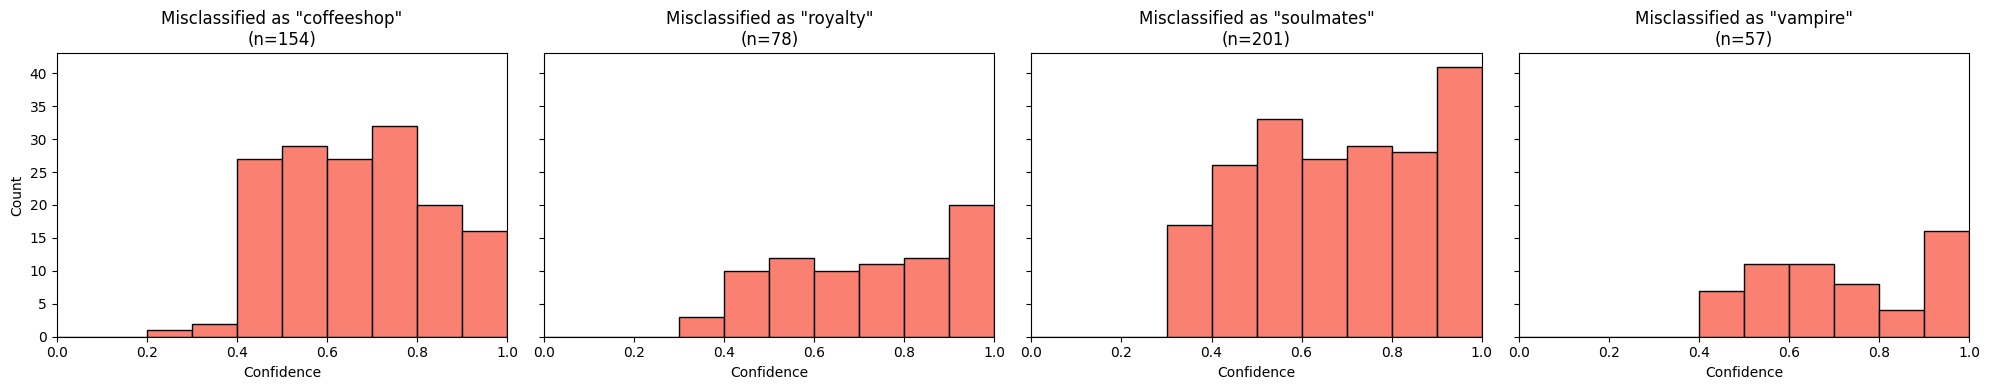

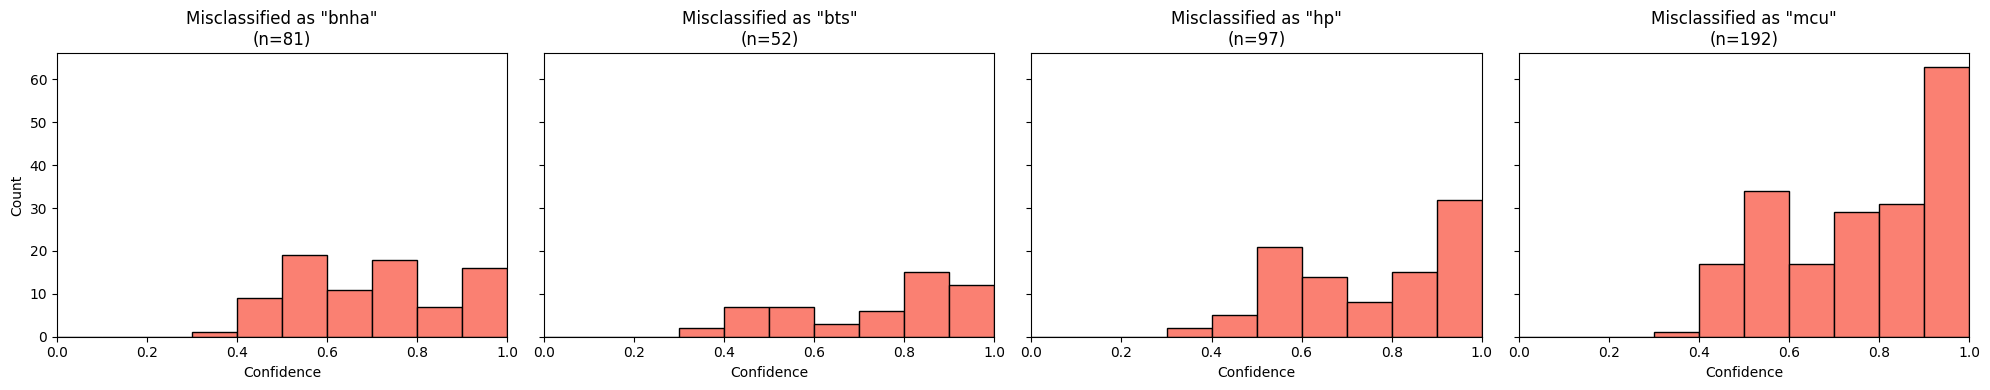

In [41]:
main()

In [31]:
model_extras = os.path.join("..", "obj", "model_extras")
models = os.path.join("..", "obj", "models")
model = joblib.load(os.path.join(models, f"xgb_AU.pkl"))
X_test = joblib.load(os.path.join(model_extras, f"X_test_AU.pkl"))
y_test = joblib.load(os.path.join(model_extras, f"y_test_AU.pkl"))
class_labels = joblib.load(os.path.join(model_extras, f"class_labels_AU.pkl"))

In [34]:
preds = model.predict(X_test)
preds.shape

(4974,)